***Pregunta N°2***

***Declaración de las Librerías.***

In [32]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU está disponible.")
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("Configuración de GPU completa.")
        except RuntimeError as e:
            print(e)
else:
    print("GPU no está disponible. Usando la CPU.")
tf.config.list_logical_devices()


GPU está disponible.
Configuración de GPU completa.


[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# ***Entorno de Juego***

*Se usará un Rompecabezas de 4 filas y 5 columnas con un espacio vacío para mover las partes del rompecabezas.*

In [33]:
class Rompecabezas:
    def __init__(self, max_movimientos=50):
        self.estado_meta = np.arange(1, 21).reshape(4, 5)
        self.estado = self.estado_meta.copy()
        np.random.shuffle(self.estado.flat)
        self.acciones = ["arriba", "abajo", "izquierda", "derecha", "quedarse"]
        self.posicion_vacia = np.argwhere(self.estado == 20)[0]
        self.max_movimientos = max_movimientos
        self.movimientos_actuales = 0
        self.recompensa_acumulada = 0

    def mezclar(self):
        estado_lista = self.estado.flatten().tolist()
        random.shuffle(estado_lista)
        self.estado = np.array(estado_lista).reshape(4, 5)


    def reiniciar(self):
        self.mezclar()
        self.posicion_vacia = np.argwhere(self.estado == 20)[0]
        self.movimientos_actuales = 0
        self.recompensa_acumulada = 0
        return self.estado

    def mover(self, accion):
        x, y = self.posicion_vacia
        if accion == "arriba" and x > 0:
            self.estado[x, y], self.estado[x - 1, y] = self.estado[x - 1, y], self.estado[x, y]
            self.posicion_vacia = [x - 1, y]
        elif accion == "abajo" and x < 3:
            self.estado[x, y], self.estado[x + 1, y] = self.estado[x + 1, y], self.estado[x, y]
            self.posicion_vacia = [x + 1, y]
        elif accion == "izquierda" and y > 0:
            self.estado[x, y], self.estado[x, y - 1] = self.estado[x, y - 1], self.estado[x, y]
            self.posicion_vacia = [x, y - 1]
        elif accion == "derecha" and y < 4:
            self.estado[x, y], self.estado[x, y + 1] = self.estado[x, y + 1], self.estado[x, y]
            self.posicion_vacia = [x, y + 1]
        elif accion == "quedarse":
            self.estado[x,y], self.estado[x,y] = self.estado[x,y], self.estado[x,y]
        if self.estado[x, y] == self.estado_meta[x, y]:
            self.recompensa_acumulada += 0.00002
        else:
            self.recompensa_acumulada -= 0.00001
        self.movimientos_actuales += 1

    def obtenerRecompensa(self):
        if self.esResuelto():
            return self.recompensa_acumulada + 100
        if self.movimientos_actuales > self.max_movimientos:
            return self.recompensa_acumulada - 500
        return self.recompensa_acumulada

    def esResuelto(self):
        return np.array_equal(self.estado, self.estado_meta)

    def obtenerEstado(self):
        return self.estado.flatten()

# ***Algoritmos de Gradiente***

El modelo de Ascenso por el Gradiente utiliza el método de gradiente de política para actualizar directamente las preferencias de las acciones en lugar de estimar los valores Q.

Inicializa un vector de preferencias para cada acción.
Calcula las probabilidades de seleccionar cada acción usando la función softmax sobre las preferencias.
Elige acciones basadas en estas probabilidades.

**Hiperparámetros**
- Episodios: Número de veces que el agente interactúa con el entorno.
- Ratio de Aprendizaje (α): Determina la magnitud de los ajustes a las preferencias.
- Promedio de Recompensas: Promedio incremental de las recompensas recibidas hasta el momento.

In [34]:
class ModeloAscensoGradiente:
    def __init__(self, entorno, num_acciones):
        self.entorno = entorno
        self.num_acciones = num_acciones
        self.preferencias = np.zeros(num_acciones)
        self.probabilidades = np.zeros(num_acciones)
        self.promedio_recompensas = 0
        self.recompensas = []
        self.tiempo = 0
        self.rango = np.random.default_rng()

    def softmax(self):
        exp_h = np.exp(self.preferencias - np.max(self.preferencias))
        self.probabilidades = exp_h / np.sum(exp_h)

    def elegir_accion(self):
        self.softmax()
        return self.rango.choice(self.num_acciones, p=self.probabilidades)

    def actualizar_preferencias(self, accion, recompensa, alpha):
        self.tiempo += 1
        self.promedio_recompensas += (recompensa - self.promedio_recompensas) / self.tiempo
        for a in range(self.num_acciones):
            if a == accion:
                self.preferencias[a] += alpha * (recompensa - self.promedio_recompensas) * (1 - self.probabilidades[a])
            else:
                self.preferencias[a] -= alpha * (recompensa - self.promedio_recompensas) * self.probabilidades[a]

    def entrenar(self, episodios, ratio_aprendizaje, ciclo_muestra=100):
        self.alpha = ratio_aprendizaje
        self.episodios = episodios
        self.recompensas = np.zeros(self.episodios)

        for e in range(self.episodios):
            estado = self.entorno.reiniciar()
            terminado = False
            while not terminado:
                accion = self.elegir_accion()
                self.entorno.mover(self.entorno.acciones[accion])
                nuevo_estado = self.entorno.obtenerEstado()
                recompensa = self.entorno.obtenerRecompensa()
                terminado = self.entorno.esResuelto() or self.entorno.movimientos_actuales > self.entorno.max_movimientos
                self.recompensas[e] += recompensa
                self.actualizar_preferencias(accion, recompensa, self.alpha)
                estado = nuevo_estado
            if (e + 1) % ciclo_muestra == 0:
                self.mostrar_estado_actual(e)
        self.mostrar_estado_final()
        self.graficarResultados(self.recompensas, self.episodios)

    def mostrar_estado_actual(self, episodio):
        print(f"Episodio {episodio + 1}:")
        print("Estado del rompecabezas:")
        print(self.entorno.estado)
        print(f"Posición vacía: {self.entorno.posicion_vacia}")
        print(f"Recompensa acumulada: {self.entorno.recompensa_acumulada}")
        print(f"Preferencias: {self.preferencias}")

    def mostrar_estado_final(self):
        print("Estado final después del entrenamiento:")
        print("Estado del rompecabezas:")
        print(self.entorno.estado)
        print(f"Posición vacía: {self.entorno.posicion_vacia}")
        print(f"Recompensa acumulada: {self.entorno.recompensa_acumulada}")
        print(f"Preferencias: {self.preferencias}")

    def graficarResultados(self, recompensas, iteraciones):
        recompensa_media = np.cumsum(recompensas) / (np.arange(iteraciones) + 1)
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(recompensas, label='Algoritmo de Gradiente')
        plt.xlabel('Episodios')
        plt.ylabel('Recompensa')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(recompensa_media, label='Algoritmo de Gradiente')
        plt.xlabel('Episodios')
        plt.ylabel('Recompensa Media Acumulada')
        plt.legend()
        plt.grid(True)

        plt.show()

<ipython-input-33-ce574f534dce>:5: UserWarning: you are shuffling a 'flatiter' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(self.estado.flat)


Episodio 100:
Estado del rompecabezas:
[[20 18 14  6 17]
 [12  3  7  2  8]
 [ 9  1  4 15 10]
 [11 19 13  5 16]]
Posición vacía: [0, 0]
Recompensa acumulada: -0.01000999999999976
Preferencias: [ 29.70243955  17.70065022 -27.13647754 -39.93678332  19.67017111]
Episodio 200:
Estado del rompecabezas:
[[ 7 10 20  9 19]
 [ 1  8  3 15 11]
 [ 6  4  2 13  5]
 [12 16 18 17 14]]
Posición vacía: [0, 2]
Recompensa acumulada: -0.009979999999999762
Preferencias: [ 29.45240124  17.75015157 -27.13647754 -39.93678332  19.87070805]
Episodio 300:
Estado del rompecabezas:
[[15 17 14 20 13]
 [ 7  5 19 10 18]
 [ 4  8 12  9  2]
 [ 6  1 11 16  3]]
Posición vacía: [0 3]
Recompensa acumulada: -0.01000999999999976
Preferencias: [ 29.05354657  17.75017104 -27.13647754 -39.93678332  20.26954325]
Episodio 400:
Estado del rompecabezas:
[[ 8  5  7 17 18]
 [ 2  4  3 15 19]
 [16 12 10 13  1]
 [ 9 20  6 11 14]]
Posición vacía: [3 1]
Recompensa acumulada: -0.01000999999999976
Preferencias: [ 16.5769303   17.94426712 -27.1

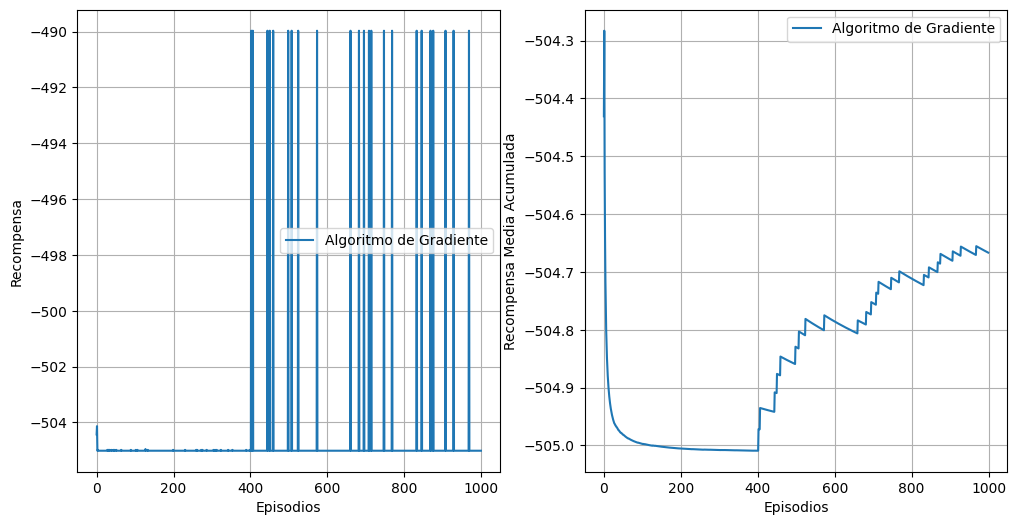

In [35]:
entorno = Rompecabezas(max_movimientos=1000)
num_acciones = len(entorno.acciones)
modelo = ModeloAscensoGradiente(entorno, num_acciones)
modelo.entrenar(episodios=1000, ratio_aprendizaje=0.1, ciclo_muestra=100)

# ***Algoritmos basados en una Q Tabla***

**Creación de la clase ModeloQLearning.**
Dicha clase heredará ciertos atributos que son comunes entre los modelos, así se tendrá un código más generalizado.

In [36]:
class ModeloQLearning:
    def __init__(self, entorno, num_acciones):
        self.entorno = entorno
        self.num_acciones = num_acciones
        self.q_tabla = np.zeros((20, num_acciones))
        self.rango = np.random.default_rng()
        self.e = 0

    def guardar_q_tabla(self, nombre_archivo):
        np.savetxt(nombre_archivo, self.q_tabla.flatten(), delimiter=",")

    def cargar_q_tabla(self, nombre_archivo):
        q_tabla_flat = np.loadtxt(nombre_archivo, delimiter=",")
        self.q_tabla = q_tabla_flat.reshape((20, self.num_acciones))

    def elegir_accion(self, estado, epsilon):
        if self.rango.random() < epsilon:
            return self.rango.integers(self.num_acciones)
        else:
            return np.argmax(self.q_tabla[estado])

    def actualizar_q_tabla(self, estado, accion, recompensa, siguiente_estado, alpha, gamma):
        mejor_q_siguiente = np.max(self.q_tabla[siguiente_estado])
        self.q_tabla[estado, accion] += alpha * (recompensa + gamma * mejor_q_siguiente - self.q_tabla[estado, accion])

    def graficar_resultados(self, recompensas, iteraciones, epsilon):
        recompensa_media = np.cumsum(recompensas) / (np.arange(iteraciones) + 1)
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(recompensas, label=f'ε = {epsilon}')
        plt.xlabel('Experiencias')
        plt.ylabel('Recompensa media')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(recompensa_media, label=f'ε = {epsilon}')
        plt.xlabel('Experiencias')
        plt.ylabel('Recompensa media acumulada')
        plt.legend()
        plt.grid(True)
        plt.show()

# ***Acción Valor.***

El modelo *acción valor* es un algoritmo de aprendizaje por refuerzo que utiliza una tabla Q (q_tabla) para almacenar los valores estimados de las acciones en diferentes estados. El objetivo es aprender la política óptima que maximiza la recompensa acumulada.

Inicializa una tabla Q con valores cero.
Durante cada episodio, el agente elige acciones basadas en una política ε-greedy (con probabilidad ε de explorar acciones aleatorias y con probabilidad 1-ε de explotar las mejores acciones conocidas).

**Hiperparámetros**
- Episodios: Número de veces que el agente interactúa con el entorno.
- Ratio de Aprendizaje (α): Determina cuánto se actualizan los valores Q.
- Probabilidad de Exploración (ε): Controla el equilibrio entre exploración y explotación.
- Factor de Descuento (γ): Pondera la importancia de las recompensas futuras.

In [37]:
class ModeloAV(ModeloQLearning):
    def __init__(self, entorno, num_acciones):
        super().__init__(entorno, num_acciones)

    def entrenar(self, episodios, ratio_aprendizaje, probabilidad_exploracion, decaimiento_epsilon, factor_descuento, ciclo_muestra=100):
        print("Modelo de Acción Valor.\n")
        self.alpha = ratio_aprendizaje
        self.epsilon_decay = decaimiento_epsilon
        self.epsilon = probabilidad_exploracion
        self.e = self.epsilon
        self.gamma = factor_descuento
        self.episodios = episodios
        self.recompensas = np.zeros(self.episodios)
        nombre_q_tabla = 'q_tabla_accion_valor.txt'
        self.guardar_q_tabla(nombre_q_tabla)

        for e in range(self.episodios):
            estado = self.entorno.reiniciar()
            terminado = False
            while not terminado:
                estado_discreto = int(np.argmax(estado))
                accion = self.elegir_accion(estado_discreto, self.epsilon)
                self.entorno.mover(self.entorno.acciones[accion])
                nuevo_estado = self.entorno.obtenerEstado()
                siguiente_estado_discreto = int(np.argmax(nuevo_estado))
                recompensa = self.entorno.obtenerRecompensa()
                terminado = self.entorno.esResuelto() or self.entorno.movimientos_actuales > self.entorno.max_movimientos
                self.recompensas[e] += recompensa

                self.actualizar_q_tabla(estado_discreto, accion, recompensa, siguiente_estado_discreto, self.alpha, self.gamma)
                estado = nuevo_estado

            if (e + 1) % ciclo_muestra == 0:
                self.mostrar_estado_actual(e)
                self.guardar_q_tabla(nombre_q_tabla)

            self.epsilon = max(self.epsilon - self.epsilon_decay, 0.01)

        self.guardar_q_tabla(nombre_q_tabla)
        self.mostrar_estado_final()
        self.graficar_resultados(self.recompensas, self.episodios, self.e)

    def mostrar_estado_actual(self, episodio):
        print(f"Episodio {episodio + 1}:")
        print("Estado del rompecabezas:")
        print(self.entorno.estado)
        print(f"Posición vacía: {self.entorno.posicion_vacia}")
        print(f"Recompensa acumulada: {self.entorno.recompensa_acumulada}")
        print(f"Q-Tabla: {self.q_tabla}")

    def mostrar_estado_final(self):
        print("Estado final después del entrenamiento:")
        print("Estado del rompecabezas:")
        print(self.entorno.estado)
        print(f"Posición vacía: {self.entorno.posicion_vacia}")
        print(f"Recompensa acumulada: {self.entorno.recompensa_acumulada}")
        print(f"Q-Tabla: {self.q_tabla}")

<ipython-input-33-ce574f534dce>:5: UserWarning: you are shuffling a 'flatiter' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(self.estado.flat)


Modelo de Acción Valor.

Episodio 100:
Estado del rompecabezas:
[[15  1  2  8 11]
 [16  9  7 20  6]
 [19 12  5 17 18]
 [14  4  3 13 10]]
Posición vacía: [1, 3]
Recompensa acumulada: -0.0082399999999998
Q-Tabla: [[ -0.06058397  -0.05994795  -1.96990864  -0.06320278  -0.0623205 ]
 [ -0.06345595  -0.06215411  -0.06124385  -0.06394741  -0.06379912]
 [ -0.07050338  -0.06281956  -0.06342931  -0.06636928  -0.06544343]
 [-32.87174652  -0.06607239  -0.06478707  -0.06695575  -0.06641868]
 [ -0.19045706  -0.06618482  -0.06662946  -0.06710207  -0.06696929]
 [ -0.06101741  -7.56565801  -0.05986823  -0.06184135  -0.06016688]
 [ -0.06322469  -0.06295199  -0.06069306  -0.06314739  -0.06201864]
 [ -0.06450545  -0.06330589  -0.0620342   -0.0653846   -0.06320776]
 [ -0.06696215  -0.06525276  -0.06351275  -0.06709433  -0.06492718]
 [ -0.06767409  -0.06811971  -0.0652166   -0.06707642  -0.06640572]
 [ -0.06035372  -0.17243432  -0.06190698  -0.06263714  -0.0614035 ]
 [ -0.06139237  -0.06345056  -0.60109698 

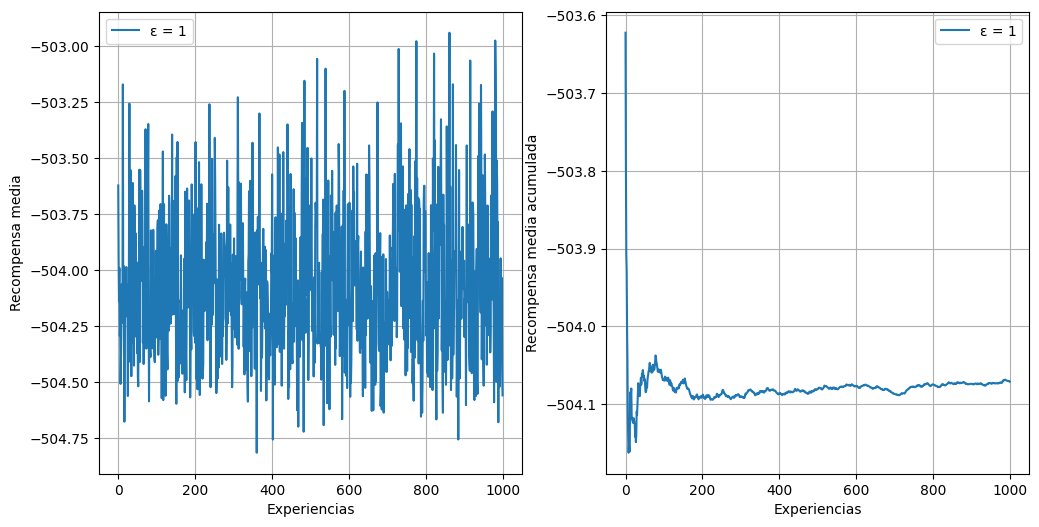

In [38]:
entorno = Rompecabezas(max_movimientos=1000)
num_acciones = len(entorno.acciones)
modelo = ModeloAV(entorno, num_acciones)
modelo.entrenar(episodios=1000, ratio_aprendizaje=0.1, probabilidad_exploracion=1, decaimiento_epsilon=0.0001, factor_descuento=0.95, ciclo_muestra=100)

# ***Valores Iniciales Optimistas.***

Este modelo inicializa la tabla q con valores altos (optimistas). Esto fomenta la exploración, ya que al principio, todas las acciones parecen tener un alto valor potencial.

Inicializa la tabla Q con valores altos en lugar de ceros.

Sigue el mismo procedimiento de actualización de Q-Learning.

Utiliza la misma política ε-greedy para elegir acciones.

**Hiperparámetros**

- Valor Inicial: Valor con el que se inicializan las entradas de la tabla Q.
- Episodios: Número de veces que el agente interactúa con el entorno.
- Ratio de Aprendizaje (α): Determina cuánto se actualizan los valores Q.
- Probabilidad de Exploración (ε): Controla el equilibrio entre exploración y explotación.
- Factor de Descuento (γ): Pondera la importancia de las recompensas futuras.

In [39]:
class ModeloVIO(ModeloQLearning):
    def __init__(self, entorno, num_acciones, valor_inicial):
        super().__init__(entorno, num_acciones)
        self.q_tabla = np.full((20, num_acciones), valor_inicial)

    def entrenar(self, episodios, ratio_aprendizaje, probabilidad_exploracion, decaimiento_epsilon, factor_descuento, ciclo_muestra=100):
        print("Modelo de Valores Iniciales Optimistas.\n")
        self.alpha = ratio_aprendizaje
        self.epsilon_decay = decaimiento_epsilon
        self.epsilon = probabilidad_exploracion
        self.gamma = factor_descuento
        self.episodios = episodios
        self.e = self.epsilon
        self.recompensas = np.zeros(self.episodios)
        nombre_q_tabla = 'q_tabla_valores_iniciales_optimistas.txt'
        self.guardar_q_tabla(nombre_q_tabla)

        for e in range(self.episodios):
            estado = self.entorno.reiniciar()
            terminado = False
            while not terminado:
                estado_discreto = int(np.argmax(estado))
                accion = self.elegir_accion(estado_discreto, self.epsilon)
                self.entorno.mover(self.entorno.acciones[accion])
                nuevo_estado = self.entorno.obtenerEstado()
                siguiente_estado_discreto = int(np.argmax(nuevo_estado))
                recompensa = self.entorno.obtenerRecompensa()
                terminado = self.entorno.esResuelto() or self.entorno.movimientos_actuales > self.entorno.max_movimientos
                self.recompensas[e] += recompensa

                self.actualizar_q_tabla(estado_discreto, accion, recompensa, siguiente_estado_discreto, self.alpha, self.gamma)
                estado = nuevo_estado

            if (e + 1) % ciclo_muestra == 0:
                self.mostrar_estado_actual(e)
                self.guardar_q_tabla(nombre_q_tabla)

            self.epsilon = max(self.epsilon - self.epsilon_decay, 0.01)

        self.guardar_q_tabla(nombre_q_tabla)
        self.mostrar_estado_final()
        self.graficar_resultados(self.recompensas, self.episodios, self.e)

    def mostrar_estado_actual(self, episodio):
        print(f"Episodio {episodio + 1}:")
        print("Estado del rompecabezas:")
        print(self.entorno.estado)
        print(f"Posición vacía: {self.entorno.posicion_vacia}")
        print(f"Recompensa acumulada: {self.entorno.recompensa_acumulada}")
        print(f"Q-Tabla: {self.q_tabla}")

    def mostrar_estado_final(self):
        print("Estado final después del entrenamiento:")
        print("Estado del rompecabezas:")
        print(self.entorno.estado)
        print(f"Posición vacía: {self.entorno.posicion_vacia}")
        print(f"Recompensa acumulada: {self.entorno.recompensa_acumulada}")
        print(f"Q-Tabla: {self.q_tabla}")


<ipython-input-33-ce574f534dce>:5: UserWarning: you are shuffling a 'flatiter' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(self.estado.flat)


Modelo de Valores Iniciales Optimistas.

Episodio 100:
Estado del rompecabezas:
[[20  9 13  6 10]
 [ 8 14 18 19 17]
 [ 3 15 11  4 12]
 [ 1  7  2  5 16]]
Posición vacía: [0, 0]
Recompensa acumulada: -0.007939999999999817
Q-Tabla: [[  0   0   0   0 -50]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0  -3]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0 -36   0   0]
 [  0   0   0   0   0]
 [ -4   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]]
Episodio 200:
Estado del rompecabezas:
[[ 6 10  1 16 18]
 [ 2  7  5 20 12]
 [ 8 17 13 15 11]
 [ 4  3 19 14  9]]
Posición vacía: [1, 3]
Recompensa acumulada: -0.0075799999999998265
Q-Tabla: [[  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [ -4   0   0   0   0]
 [  0 

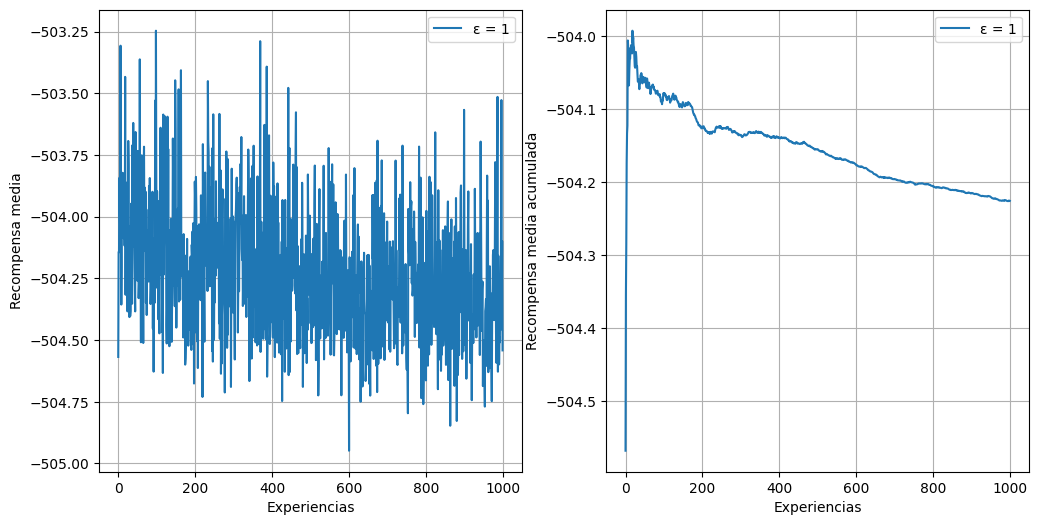

In [40]:
entorno = Rompecabezas(max_movimientos=1000)
num_acciones = len(entorno.acciones)
valor_inicial = 10000
modelo = ModeloVIO(entorno, num_acciones, valor_inicial)
modelo.entrenar(episodios=1000, ratio_aprendizaje=0.1, probabilidad_exploracion=1, decaimiento_epsilon=0.0001, factor_descuento=0.9, ciclo_muestra=100)

# ***Selección de Acciones con Intérvalo de Confianza.***

Este modelo implementa una estrategia de selección de acciones basada en intervalos de confianza, donde se eligen acciones no solo por su valor esperado, sino también considerando la incertidumbre en las estimaciones.

Inicializa una tabla Q y un contador de acciones.
Durante cada episodio, el agente selecciona acciones basándose en una combinación del valor estimado y un término de exploración que decrece con el número de veces que se ha elegido la acción.
Actualiza la tabla Q y el contador de acciones después de cada interacción con el entorno.

**Hiperparámetros**

- Episodios: Número de veces que el agente interactúa con el entorno.
- Ratio de Aprendizaje (α): Determina cuánto se actualizan los valores Q.
- Probabilidad de Exploración (ε): Controla el equilibrio entre exploración y explotación.
- Factor de Descuento (γ): Pondera la importancia de las recompensas futuras.

In [41]:
class ModeloAIC(ModeloQLearning):
    def __init__(self, entorno, num_acciones):
        super().__init__(entorno, num_acciones)
        self.tiempo = 0
        self.contadores_accion = np.zeros((20, num_acciones))

    def elegir_accion(self, estado, confianza):
        self.tiempo += 1
        total_acciones = np.sum(self.contadores_accion[estado]) + 1
        valores_ucb = self.q_tabla[estado] + confianza * np.sqrt(np.log(total_acciones) / (self.contadores_accion[estado] + 1))
        return np.argmax(valores_ucb)

    def entrenar(self, episodios, ratio_aprendizaje, confianza, factor_descuento, ciclo_muestra=100):
        print("Modelo de Acciones con Intervalo de Confianza.\n")
        self.alpha = ratio_aprendizaje
        self.gamma = factor_descuento
        self.episodios = episodios
        self.recompensas = np.zeros(self.episodios)
        nombre_q_tabla = 'q_tabla_ucb.txt'
        self.guardar_q_tabla(nombre_q_tabla)

        for e in range(self.episodios):
            estado = self.entorno.reiniciar()
            terminado = False
            while not terminado:
                estado_discreto = int(np.argmax(estado))
                accion = self.elegir_accion(estado_discreto, confianza)
                self.entorno.mover(self.entorno.acciones[accion])
                nuevo_estado = self.entorno.obtenerEstado()
                siguiente_estado_discreto = int(np.argmax(nuevo_estado))
                recompensa = self.entorno.obtenerRecompensa()
                terminado = self.entorno.esResuelto() or self.entorno.movimientos_actuales > self.entorno.max_movimientos
                self.recompensas[e] += recompensa

                self.actualizar_q_tabla(estado_discreto, accion, recompensa, siguiente_estado_discreto, self.alpha, self.gamma)
                estado = nuevo_estado

            if (e + 1) % ciclo_muestra == 0:
                self.mostrar_estado_actual(e)
                self.guardar_q_tabla(nombre_q_tabla)

        self.guardar_q_tabla(nombre_q_tabla)
        self.mostrar_estado_final()
        self.graficar_resultados(self.recompensas, self.episodios, confianza)

    def mostrar_estado_actual(self, episodio):
        print(f"Episodio {episodio + 1}:")
        print("Estado del rompecabezas:")
        print(self.entorno.estado)
        print(f"Posición vacía: {self.entorno.posicion_vacia}")
        print(f"Recompensa acumulada: {self.entorno.recompensa_acumulada}")
        print(f"Q-Tabla: {self.q_tabla}")

    def mostrar_estado_final(self):
        print("Estado final después del entrenamiento:")
        print("Estado del rompecabezas:")
        print(self.entorno.estado)
        print(f"Posición vacía: {self.entorno.posicion_vacia}")
        print(f"Recompensa acumulada: {self.entorno.recompensa_acumulada}")
        print(f"Q-Tabla: {self.q_tabla}")


<ipython-input-33-ce574f534dce>:5: UserWarning: you are shuffling a 'flatiter' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(self.estado.flat)


Modelo de Acciones con Intervalo de Confianza.

Episodio 100:
Estado del rompecabezas:
[[11  6 20  4  3]
 [12  2 18  9 17]
 [19 13 15 16  7]
 [14  5  8 10  1]]
Posición vacía: [0, 2]
Recompensa acumulada: -0.01000999999999976
Q-Tabla: [[-7.35257206e-02 -7.35535209e-02 -5.00384394e+01 -4.61844632e-01
  -5.00394223e+01]
 [-5.00090375e+01 -5.00523198e+01 -5.00260624e+01 -2.53091877e-01
  -5.00858228e+01]
 [-7.03311293e+01 -5.33610039e+01 -5.02522873e+01 -5.20025984e+01
  -5.00925440e+01]
 [-5.00811530e+01 -2.24636217e+00 -3.70117322e+00 -4.57348004e+00
  -5.00611195e+01]
 [-5.00918356e+01 -5.00784187e+01 -3.02856387e+01 -5.00850904e+01
  -6.55079283e+01]
 [-7.35022490e-02 -7.35144944e-02 -7.36184017e-02 -4.10493584e+00
  -5.00736506e+01]
 [-5.96063159e+01 -5.12114265e+01 -7.95566228e+01 -5.02211569e+01
  -5.00919206e+01]
 [-2.82627054e+01 -5.00402461e+01 -2.77028126e+01 -5.00043336e+01
  -5.00636388e+01]
 [-5.00841831e+01 -2.20318232e+00 -5.00532879e+01 -2.67789685e+00
  -5.00518581e+01]


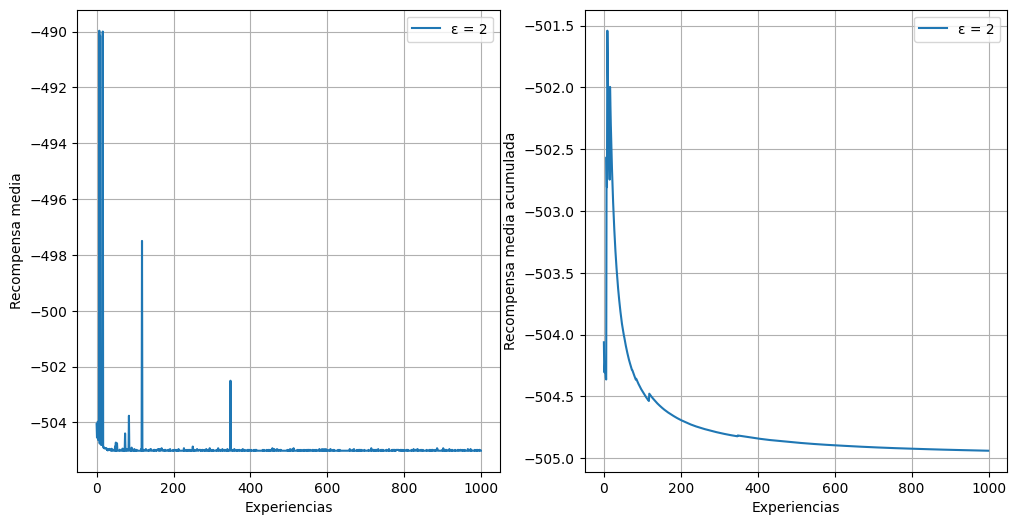

In [42]:
entorno = Rompecabezas(max_movimientos=1000)
num_acciones = len(entorno.acciones)
confianza = 2
modelo = ModeloAIC(entorno, num_acciones)
modelo.entrenar(episodios=1000, ratio_aprendizaje=0.1, confianza=confianza, factor_descuento=0.9, ciclo_muestra=100)